# 저장된 SSD 모델 학습하여 모자 Object Detection
-  Colab에 images.zip, GDUT_HWD.json, ssd160-mobilenet.h5 3개 파일 업로드

In [2]:
!git clone https://github.com/hukim1112/MLDL.git

Cloning into 'MLDL'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 247 (delta 74), reused 222 (delta 49), pack-reused 0
Receiving objects: 100% (247/247), 56.08 MiB | 41.76 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [26]:
import numpy as np
import tensorflow as tf
import json, os, sys, time
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
sys.path.append("/content/MLDL/object_detection")

In [5]:
import anchor, losses, manage_checkpoint

In [6]:
config = {
    "exp_desc" : "perfection", #실험명
    "sub_desc" : "exp1", #하위실험명
    "image_dir" : "/content/images", #이미지경로
    "coco_api" : "/home/dan/prj/PythonAPI",
    "annotation_dir" : "/content/", #어노테이션 경로
    "label_set" : ["head","helmet"], # 분류할 오브젝트 집합
    "input_shape" : [160, 160, 3], #모델입력영상 크기
    "arch" : "ssd160",
    "backbone" : "mobilenet",
    "anchor_param" : {"ratios": [[2], [2, 3], [2, 3], [2]],
                           "scales": [0.1, 0.3, 0.6, 0.9, 1.05],
                           "fm_sizes": [10, 5, 3, 1],
                           "image_size": 160}, #anchor parameters
    "ckpt":
    {
        "save_type" : "best",
        "max_to_keep" : 10,
        "pretrained_type" : "init",
        "model_path" : None
    },
    "inference_mode" : "train", # train or mAP
    "train" :
    {
        "num_examples" : -1,
        "batch_size" : 16,
        "augmentation" : True,
        "random_crop_rate" : 0.3,
        "neg_ratio" : 3,
        "initial_lr" : 1e-3,
        "momentum" : 0.9,
        "weight_decay" : 5e-5,
        "num_epochs" : 300
    },
    "val":
    {
        "num_examples" : -1,
        "batch_size" : 64
    },
    "test":
    {
        "num_examples" : -1,
        "batch_size" : 1
    }

}
num_classes = len(config['label_set'])+1
log_dir = os.path.join('logs', 'perfection', 'exp1')
# if os.path.isdir(ckpt_dir):
#     raise ValueError("checkpoint directory exists. checkout your experiment name in configure file.")
# if os.path.isdir(log_dir):
#     raise ValueError("log directory exists. checkout your experiment name in configure file.")


# Dataset load

In [10]:
from pycocotools.coco import COCO
# test COCO api can load my json file
json = COCO("/content/GDUT_HWD.json")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [11]:
!ls images.zip
!unzip images.zip

images.zip
Archive:  images.zip
   creating: images/
  inflating: images/00170.jpg        
  inflating: images/02310.jpg        
  inflating: images/03141.jpg        
  inflating: images/01077.jpg        
  inflating: images/03327.jpg        
  inflating: images/02538.jpg        
  inflating: images/00290.jpg        
  inflating: images/02007.jpg        
  inflating: images/02587.jpg        
  inflating: images/01710.jpg        
  inflating: images/02081.jpg        
  inflating: images/03041.jpg        
  inflating: images/01447.jpg        
  inflating: images/02306.jpg        
  inflating: images/01312.jpg        
  inflating: images/02139.jpg        
  inflating: images/00571.jpg        
  inflating: images/01790.jpg        
  inflating: images/00984.jpg        
  inflating: images/01381.jpg        
  inflating: images/03386.jpg        
  inflating: images/02526.jpg        
  inflating: images/02877.jpg        
  inflating: images/00058.jpg        
  inflating: images/00574.jpg      

In [12]:
from coco import Dataset
ds_obj = Dataset(config, COCO)

In [13]:
batch_generator, train_length = ds_obj.load_data_generator('train', config)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [14]:
for i, (_, imgs, gt_confs, gt_locs) in enumerate(batch_generator.take(1)):
    print(imgs.shape, gt_confs.shape, gt_locs.shape)

(16, 160, 160, 3) (16, 608) (16, 608, 4)


# Model load

In [15]:
model = tf.keras.models.load_model("ssd160-mobilenet.h5")

In [16]:
model.layers[1].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10, 10, 576)  616256      input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5, 5, 512)    569344      model[0][0]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3, 3, 512)    536576      sequential[0][0]                 
____________________________________________________________________________________________

In [17]:
model(imgs)

[<tf.Tensor: shape=(16, 608, 3), dtype=float32, numpy=
 array([[[-1.1070409e+00, -4.9200040e-01,  3.6914706e-01],
         [-9.6895635e-01, -6.0364008e-03,  8.2936740e-01],
         [-4.6101460e-01, -4.6475235e-01,  1.0082830e+00],
         ...,
         [ 3.4347272e-06, -1.2454613e-05, -5.7820776e-06],
         [-5.3809399e-06, -4.3829041e-06,  2.7022891e-06],
         [-2.3621403e-06, -7.9445908e-07,  5.6567683e-06]],
 
        [[-6.4291310e-01, -6.2628293e-01,  3.1403869e-01],
         [-4.4301599e-03,  2.9485655e-01,  7.7143204e-01],
         [-2.9573083e-02, -2.6309371e-01,  3.9318597e-01],
         ...,
         [ 7.4716661e-07, -9.8049295e-06, -5.3729336e-06],
         [-6.3562766e-06, -6.2733325e-06,  1.5093922e-06],
         [-6.7149074e-07, -2.6490298e-07,  5.6046792e-06]],
 
        [[-9.0326583e-01, -7.0264381e-01,  4.8749828e-01],
         [-1.3064504e-01, -2.6594520e-01,  8.8560593e-01],
         [-1.8699074e-01, -2.2850947e-01,  1.8719897e-01],
         ...,
         [ 9

# Training loop

In [18]:
@tf.function
def train_step(imgs, gt_confs, gt_locs, ssd, criterion, optimizer, config):
    with tf.GradientTape() as tape:
        confs, locs = ssd(imgs)

        conf_loss, loc_loss = criterion(
            confs, locs, gt_confs, gt_locs)

        loss = conf_loss + loc_loss
        l2_loss = [tf.nn.l2_loss(t) for t in ssd.trainable_variables]
        l2_loss = config['train']['weight_decay'] * tf.math.reduce_sum(l2_loss)
        loss += l2_loss

    gradients = tape.gradient(loss, ssd.trainable_variables)
    optimizer.apply_gradients(zip(gradients, ssd.trainable_variables))

    return loss, conf_loss, loc_loss, l2_loss

criterion = losses.create_losses(config['train']['neg_ratio'], num_classes)

In [19]:
summary_writer = tf.summary.create_file_writer(log_dir)

t_loss = tf.metrics.Mean(name='train_loss')
t_conf_loss = tf.metrics.Mean(name='train_conf_loss')
t_loc_loss = tf.metrics.Mean(name='train_loc_loss')
# v_loss = tf.metrics.Mean(name='val_loss')
# v_conf_loss = tf.metrics.Mean(name='val_conf_loss')
# v_loc_loss = tf.metrics.Mean(name='val_loc_loss')

learning_rate = 1E-3
EPOCH = 50
START = 0
optimizer = tf.keras.optimizers.Adam(learning_rate)
for epoch in range(START+1, START+EPOCH+1):
    start = time.time()
    for i, (_, imgs, gt_confs, gt_locs) in enumerate(batch_generator):
        imgs = preprocess_input(imgs)
        loss, conf_loss, loc_loss, l2_loss = train_step(imgs, gt_confs, gt_locs, model, criterion, optimizer, config)
        t_loss(loss)
        t_conf_loss(conf_loss)
        t_loc_loss(loc_loss)
        
        print("Epoch {} iteration {} loss : {}".format(epoch, i, t_loss.result()))
    
    '''
    you can add the validation part
    
    for i, (_, imgs, gt_confs, gt_locs) in enumerate(val_generator):
        imgs = preprocess_input(imgs)
        val_confs, val_locs = model(imgs)
        val_conf_loss, val_loc_loss = criterion(val_confs, val_locs, gt_confs, gt_locs)
        v_loss(val_conf_loss+val_loc_loss)
        v_conf_loss(val_conf_loss)
        v_loc_loss(val_loc_loss)
    '''
    # Save checkpoint with a strategy.
    if epoch%10 == 0:
        model.save("{}.h5".format(epoch))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', t_loss.result(), step=epoch)
        tf.summary.scalar('train_conf_loss', t_conf_loss.result(), step=epoch)
        tf.summary.scalar('train_loc_loss', t_loc_loss.result(), step=epoch)
        #tf.summary.scalar('val_loss', v_loss.result(), step=epoch)
        #tf.summary.scalar('val_conf_loss', v_conf_loss.result(), step=epoch)
        #tf.summary.scalar('val_loc_loss', v_loc_loss.result(), step=epoch)
        tf.summary.scalar('learning_rate', learning_rate, step=epoch)
        
    t_loss.reset_states()
    t_conf_loss.reset_states()
    t_loc_loss.reset_states()
    #v_loss.reset_states()
    #v_conf_loss.reset_states()
    #v_loc_loss.reset_states()   

Epoch 1 iteration 0 loss : 12.688091278076172
Epoch 1 iteration 1 loss : 12.622629165649414
Epoch 1 iteration 2 loss : 11.344651222229004
Epoch 1 iteration 3 loss : 10.414131164550781
Epoch 1 iteration 4 loss : 9.730663299560547
Epoch 1 iteration 5 loss : 9.336639404296875
Epoch 1 iteration 6 loss : 9.0309476852417
Epoch 1 iteration 7 loss : 8.797061920166016
Epoch 1 iteration 8 loss : 8.5926513671875
Epoch 1 iteration 9 loss : 8.476509094238281
Epoch 2 iteration 0 loss : 6.746562480926514
Epoch 2 iteration 1 loss : 6.46551513671875
Epoch 2 iteration 2 loss : 6.07219934463501
Epoch 2 iteration 3 loss : 5.78732967376709
Epoch 2 iteration 4 loss : 5.820398807525635
Epoch 2 iteration 5 loss : 5.750316619873047
Epoch 2 iteration 6 loss : 5.8074798583984375
Epoch 2 iteration 7 loss : 5.790146827697754
Epoch 2 iteration 8 loss : 5.722734451293945
Epoch 2 iteration 9 loss : 5.578218936920166
Epoch 3 iteration 0 loss : 4.155020236968994
Epoch 3 iteration 1 loss : 4.413178443908691
Epoch 3 iter

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11 iteration 0 loss : 2.2428576946258545
Epoch 11 iteration 1 loss : 2.0198159217834473
Epoch 11 iteration 2 loss : 1.8707205057144165
Epoch 11 iteration 3 loss : 1.8102922439575195
Epoch 11 iteration 4 loss : 1.773106575012207
Epoch 11 iteration 5 loss : 1.7720428705215454
Epoch 11 iteration 6 loss : 1.7665574550628662
Epoch 11 iteration 7 loss : 1.7818059921264648
Epoch 11 iteration 8 loss : 1.800610065460205
Epoch 11 iteration 9 loss : 1.8070592880249023
Epoch 12 iteration 0 loss : 1.534254550933838
Epoch 12 iteration 1 loss : 1.6495873928070068
Epoch 12 iteration 2 loss : 1.726136565208435
Epoch 12 iteration 3 loss : 1.6829917430877686
Epoch 12 iteration 4 loss : 1.7424628734588623
Epoch 12 iteration 5 loss : 1.7238177061080933
Epoch 12 iteration 6 loss : 1.7215633392333984
Epoch 12 iteration 7 loss : 1.7099660634994507
Epoch 12 iteration 8 loss : 1.703073263168335
Epoch 12 iteration 9 loss : 1.7021220922470093
Epoch 13 iteration 0 loss : 1.4883496761322021
Epoch 13 iteration

In [20]:
from post_process import predict

default_boxes = anchor.generate_default_boxes(config["anchor_param"])
confs, locs = model(imgs, training=False) #imgs.shape == (N,160,160,3)
batch_boxes, batch_classes, batch_scores = predict(confs, locs, default_boxes, num_classes, conf_thresh=0.5)
# 각 영상별 예측 bounding box(바운딩 박스)와 class(카테고리 번호), 그리고 scores(신뢰도)

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


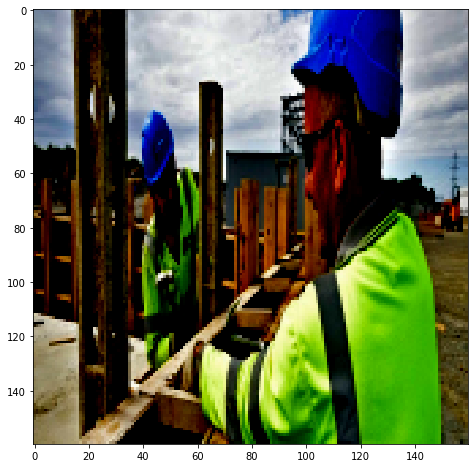

In [22]:
plt.imshow(imgs[0])

In [23]:
batch_boxes[0], batch_scores[0], batch_classes[0]

(array([[0.6007735 , 0.        , 0.86796635, 0.53145856],
        [0.25223258, 0.22160539, 0.33775148, 0.49351522]], dtype=float32),
 array([0.9938567 , 0.96332645], dtype=float32),
 array([2, 2]))

In [24]:
#config['label_set']
label_list = ['head', 'helmet']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


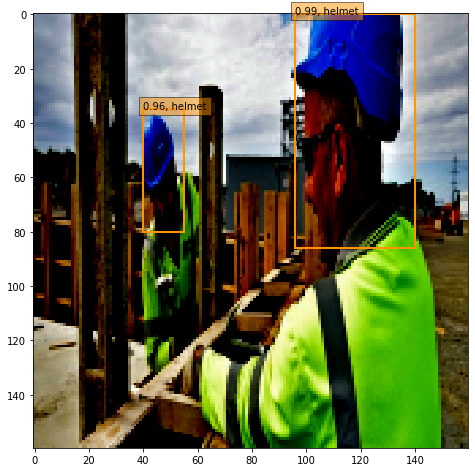

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


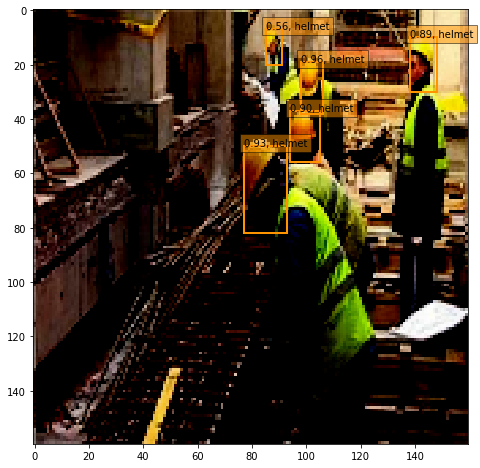

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


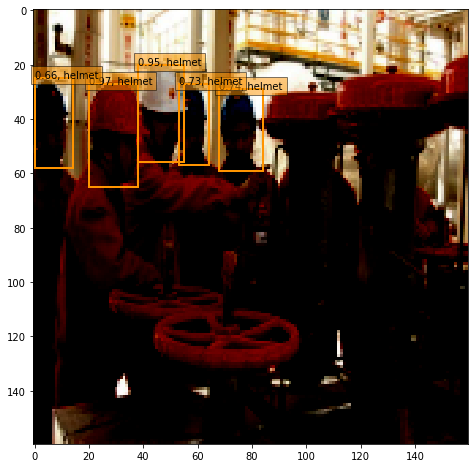

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


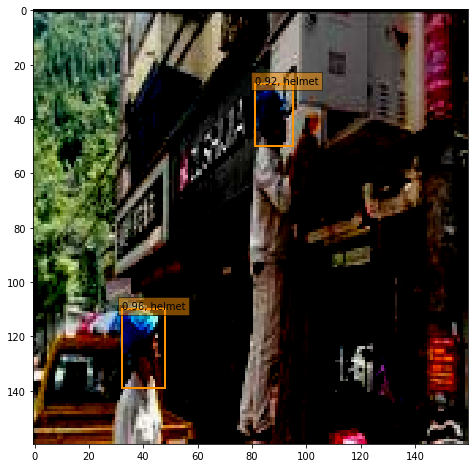

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


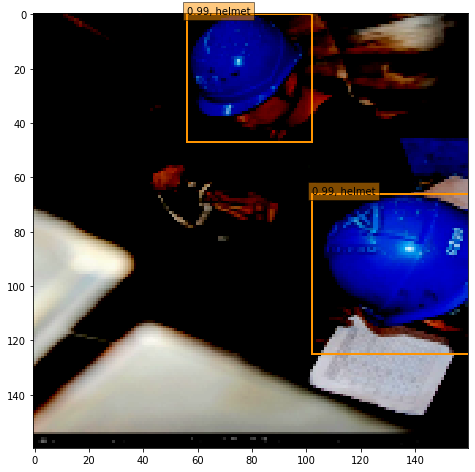

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


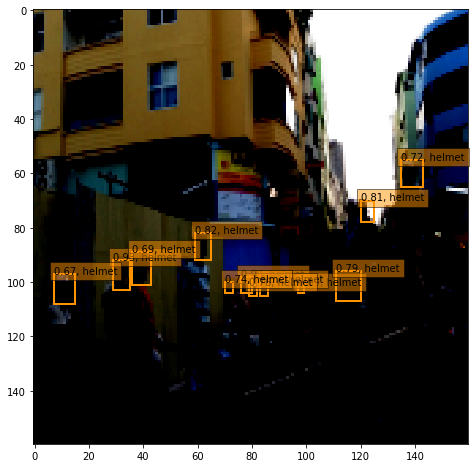

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


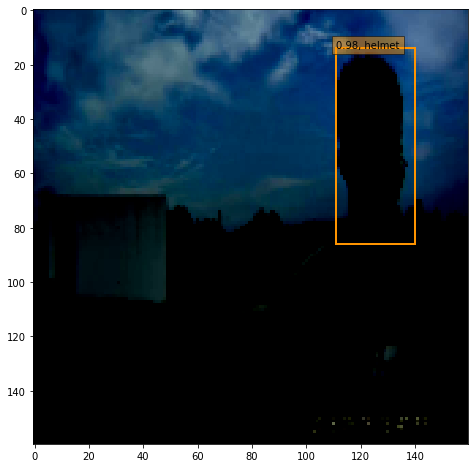

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


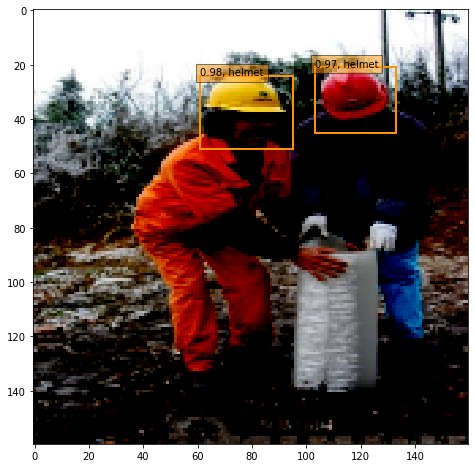

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


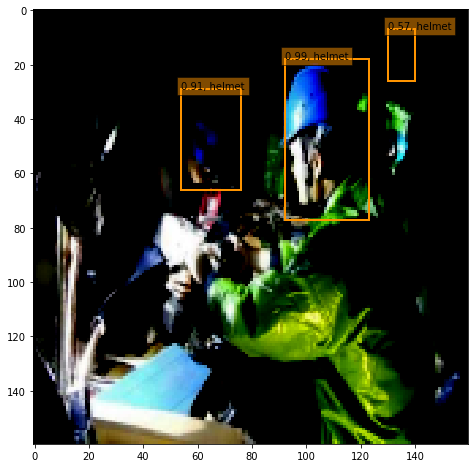

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


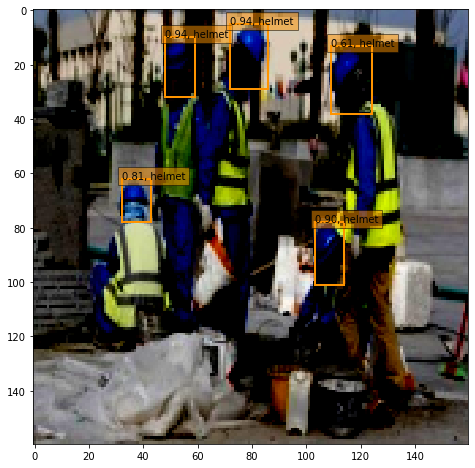

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


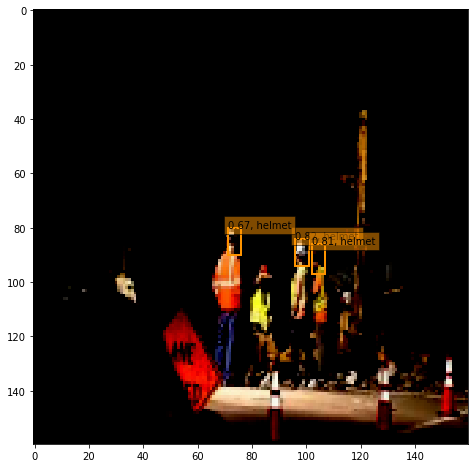

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


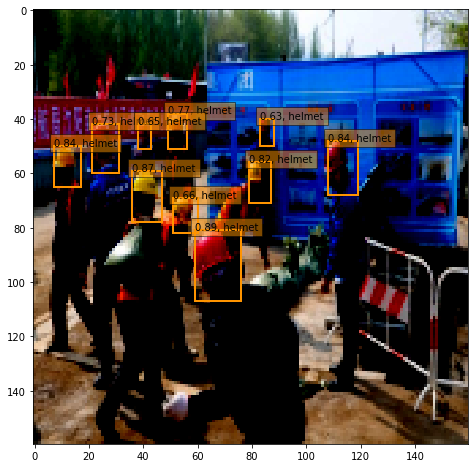

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


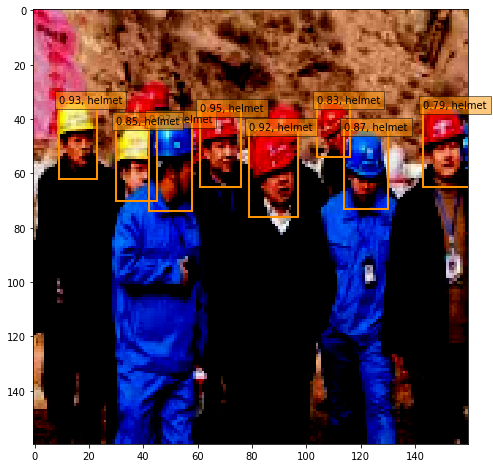

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


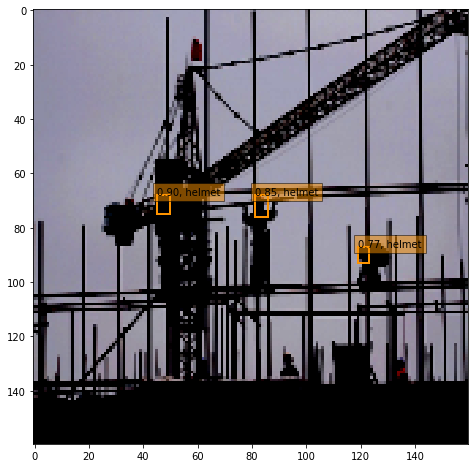

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


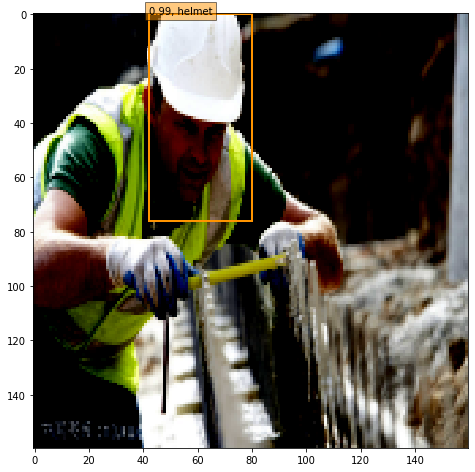

In [27]:
for x in range(imgs.shape[0]):

  img = imgs[x]
  batch_box = batch_boxes[x]
  batch_score = batch_scores[x]
  batch_class = batch_classes[x]

  colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
  currentAxis = plt.gca()
  plt.imshow(img)

  for i in range(batch_box.shape[0]):
    
    xmin = int(np.round(batch_box[i, 0] * img.shape[1]))
    ymin = int(np.round(batch_box[i, 1] * img.shape[0]))
    xmax = int(np.round(batch_box[i, 2] * img.shape[1]))
    ymax = int(np.round(batch_box[i, 3] * img.shape[0]))

    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1

    score = batch_score[i]
    label = batch_class[i]
    
    label_name = label_list[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

  plt.show()

In [28]:

import numpy as np

xmin = int(np.round(batch_boxes[0][0, 0] * imgs[0].shape[1]))
ymin = int(np.round(batch_boxes[0][0, 1] * imgs[0].shape[0]))
xmax = int(np.round(batch_boxes[0][0, 2] * imgs[0].shape[1]))
ymax = int(np.round(batch_boxes[0][0, 3] * imgs[0].shape[0]))

coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
print(xmin, ymin, xmax, ymax)
print(coords)

96 0 139 85
((96, 0), 44, 86)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(96, 0, 'aaa')

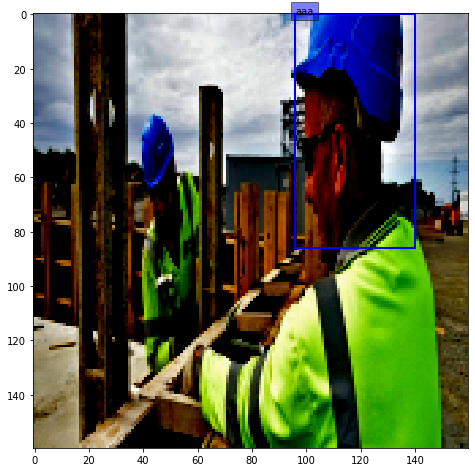

In [29]:
plt.imshow(imgs[0])

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
color = 'blue'
display_txt = 'aaa'


currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

In [30]:
batch_box

array([[0.25959635, 0.        , 0.49236798, 0.46918917]], dtype=float32)

In [31]:
imgs.shape

TensorShape([15, 160, 160, 3])